<a href="https://colab.research.google.com/github/segnig/event-driven-oil-analysis/blob/task-2/notebooks/02_change_point_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 Load the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Corrected URL to fetch the raw CSV data
url = 'https://raw.githubusercontent.com/segnig/event-driven-oil-analysis/task-2/data/BrentOilPrices_cleaned.csv'

df = pd.read_csv(url, index_col='Date')

df = df.sort_index()

df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55


## 1.2 Plot the raw Prices Series

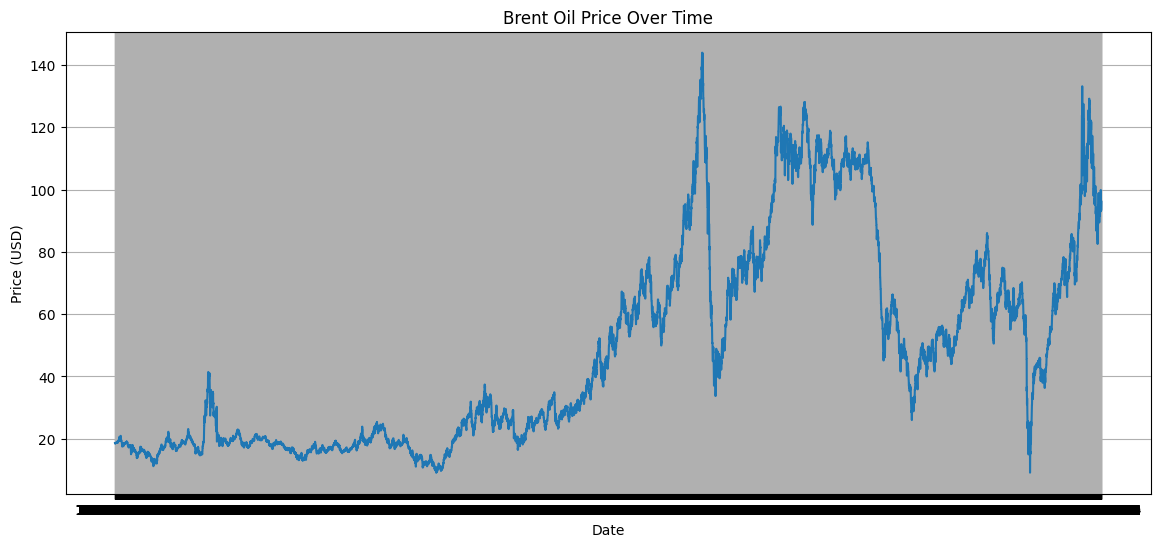

In [2]:
plt.figure(figsize=(14, 6))
plt.plot( df["Price"])
plt.title("Brent Oil Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


## 1.3 Compute Log Returns

In [3]:
df["LogReturn"] = np.log(df["Price"]).diff()
df.dropna(inplace=True)

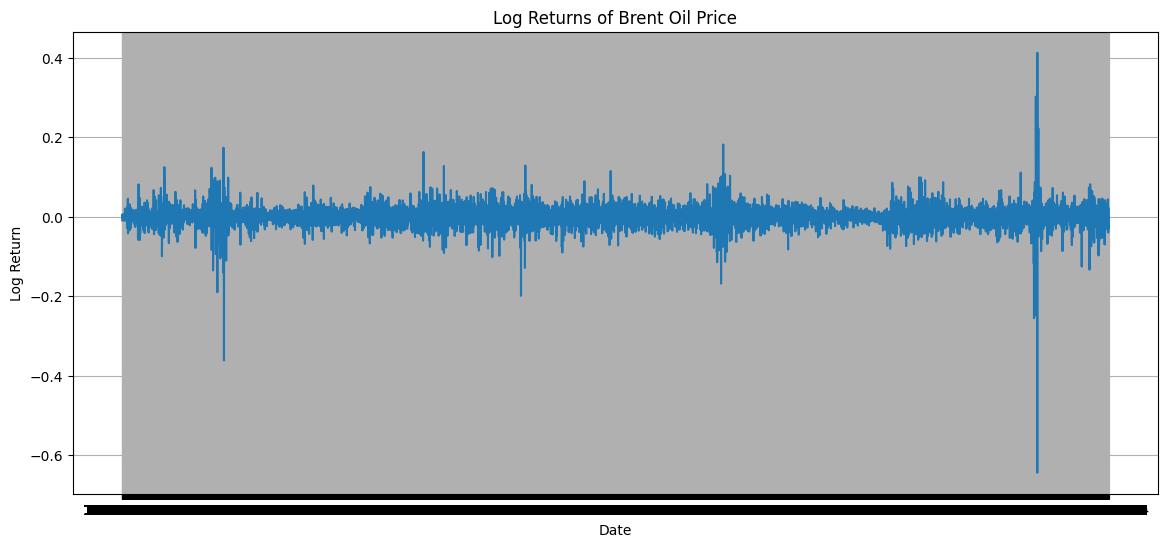

In [4]:
plt.figure(figsize=(14, 6))
plt.plot( df["LogReturn"])
plt.title("Log Returns of Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)

plt.show()


## **Build Bayesian Change Point Model using PyMC3**

In [5]:
!pip install pymc3 --quiet
!pip install arviz --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 75.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 89.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 50.8 MB/s eta 0:00:00


In [6]:
import pymc as pm

# Index for time
n = len(df)
log_returns = df["LogReturn"].values

with pm.Model() as model:
    # Prior for change point (tau) - uniform across all time steps
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    # Priors for mean before and after the change point
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)

    # Shared standard deviation (could be made separate too)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Define the mean based on change point
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### 📊 **Step 3: Analyze and Interpret Results**
## 3.1 Check for Convergence

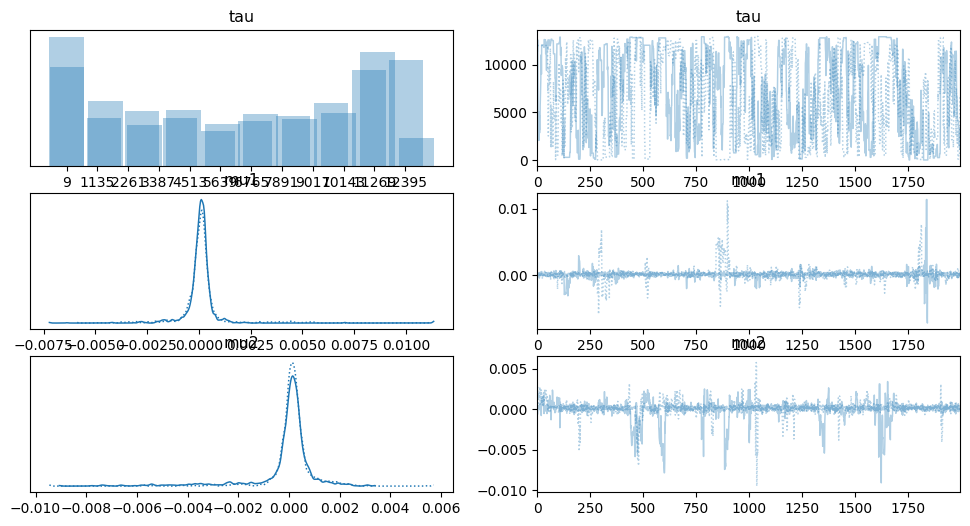

In [7]:
import arviz as az

az.summary(trace, hdi_prob=0.95)
az.plot_trace(trace, var_names=["tau", "mu1", "mu2"])
plt.show()

## 3.2 Plot Posterior of Change Point

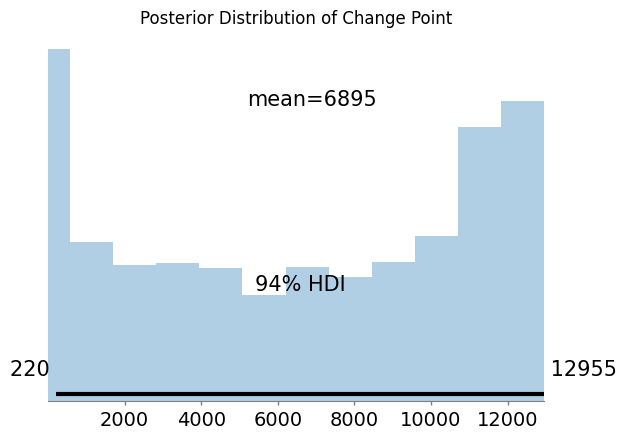

In [8]:
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Change Point")
plt.show()


In [10]:
tau_median = int(az.summary(trace).loc["tau", "mean"])
change_date = df.index[tau_median]
print(f"Most likely change point at index {tau_median}, date: {change_date}")

Most likely change point at index 6895, date: 2006-04-06


## 3.3 Quantify Impact

mu1_mean = trace.posterior["mu1"].mean().item()
mu2_mean = trace.posterior["mu2"].mean().item()
impact = ((mu2_mean - mu1_mean) / abs(mu1_mean)) * 100

print(f"Change point detected on {change_date}")
print(f"Mean before: {mu1_mean:.4f}, Mean after: {mu2_mean:.4f}")
print(f"Change in mean: {impact:.2f}%")


## 3.4 Visualize Change

plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["LogReturn"], label="Log Returns")
plt.axvline(change_date, color="red", linestyle="--", label="Change Point")
plt.title("Log Returns with Detected Change Point")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
mu1_mean = trace.posterior["mu1"].mean().item()
mu2_mean = trace.posterior["mu2"].mean().item()
impact = ((mu2_mean - mu1_mean) / abs(mu1_mean)) * 100

print(f"Change point detected on {change_date}")
print(f"Mean before: {mu1_mean:.4f}, Mean after: {mu2_mean:.4f}")
print(f"Change in mean: {impact:.2f}%")

Change point detected on 2006-04-06
Mean before: 0.0001, Mean after: -0.0000
Change in mean: -101.60%


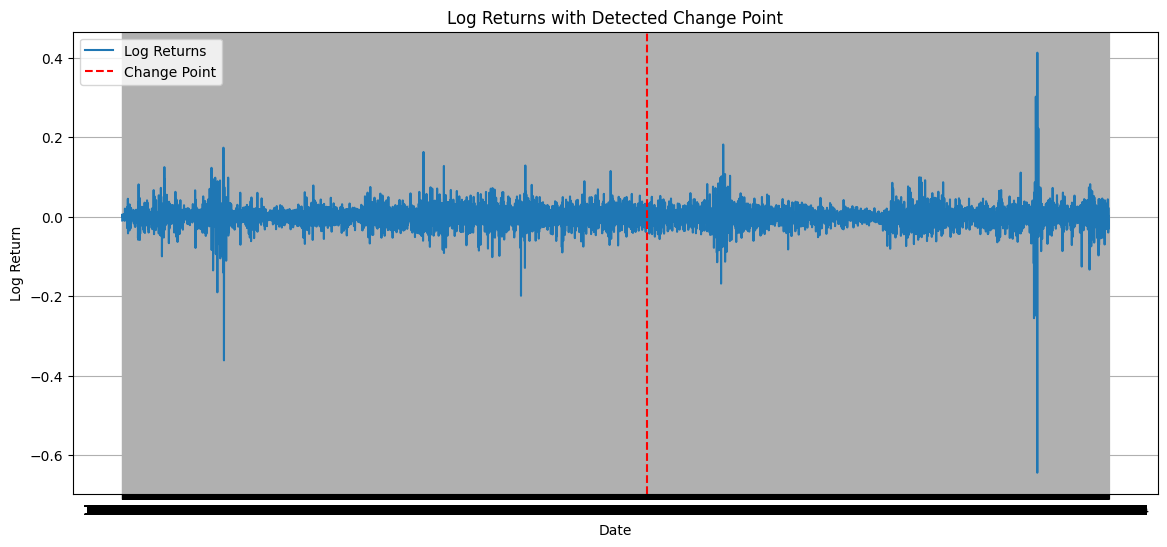

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["LogReturn"], label="Log Returns")
plt.axvline(change_date, color="red", linestyle="--", label="Change Point")
plt.title("Log Returns with Detected Change Point")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()